In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
#from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
import time
from time import gmtime, strftime
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2016-05-30 10:10:02


In [3]:
dm = pd.read_csv("ladder_durmv_allmat_longhist.csv",header=[0,1],index_col=0,parse_dates=True) ## NOTE THIS COMMAND!!!
dm.head(2)

dv12                                                    \
                  ff        mv      mvpc       dur       cpn       mv3   
1965-12-01  4.380000  9.872790  1.008227  0.534467  5.493205  4.784516   
1966-01-01  4.481389  9.288667  1.007741  0.534508  5.463205  4.955346   

                               dv24       ...   dv300                 dv360  \
             roll12m    roll3m   mv mvpc  ...     mv3 roll300m roll3m    mv   
1965-12-01  4.854038  4.998342  NaN  NaN  ...     NaN      NaN    NaN   NaN   
1966-01-01  4.916538  5.187601  NaN  NaN  ...     NaN      NaN    NaN   NaN   

                                             
           mvpc dur cpn mv3 roll360m roll3m  
1965-12-01  NaN NaN NaN NaN      NaN    NaN  
1966-01-01  NaN NaN NaN NaN      NaN    NaN  

[2 rows x 106 columns]

In [4]:
dmq = dm.resample("Q").mean()
#dmq = dmq.dropna(how='any')
dmq.head(2)

dv12                                                   \
                  ff       mv      mvpc       dur       cpn       mv3   
1965-12-31  4.380000  9.87279  1.008227  0.534467  5.493205  4.784516   
1966-03-31  4.619954  9.60940  1.008008  0.534447  5.559872  5.331311   

                               dv24       ...   dv300                 dv360  \
             roll12m    roll3m   mv mvpc  ...     mv3 roll300m roll3m    mv   
1965-12-31  4.854038  4.998342  NaN  NaN  ...     NaN      NaN    NaN   NaN   
1966-03-31  4.986816  5.337432  NaN  NaN  ...     NaN      NaN    NaN   NaN   

                                             
           mvpc dur cpn mv3 roll360m roll3m  
1965-12-31  NaN NaN NaN NaN      NaN    NaN  
1966-03-31  NaN NaN NaN NaN      NaN    NaN  

[2 rows x 106 columns]

In [5]:
dmq120=pd.DataFrame(dmq['dv120']['roll120m'])
dmq144 = dmq['dv144']['roll144m']
dmq180 = dmq['dv180']['roll180m']
dmq240 = dmq['dv240']['roll240m']
dmq300 = dmq['dv300']['roll300m']
dmq360 = dmq['dv360']['roll360m']
dmx = pd.concat([dmq120,dmq144,dmq180,dmq240,dmq300,dmq360],axis=1)

dmx.tail(2)

roll120m  roll144m  roll180m  roll240m  roll300m  roll360m
2015-09-30  3.451056  3.737475  4.185031  4.925406  5.579070  6.273378
2015-12-31  3.382139  3.682372  4.108569  4.872263  5.511085  6.202494

In [6]:
## get libor-swap history:
ls = pd.read_csv("LibSwap_LongHist_30y_201512.csv",index_col=0)
ls.index = pd.to_datetime(ls.index)
#ls = ls[:'2014']
lsq=ls['1965':].resample('Q').mean()
## prepare to build ladders:
ld = lsq[['F1d','Prime']]
ld['DDA'] = 0.
mlst = [1,3,6,12,24,36,48,60,84,120,360]  # maturity list to be used
lcol = list(ls.columns)[1:-2]
lcol.remove('L12m')
mdct = dict(zip(mlst,lcol))
len(lsq), len(ld)

(204, 204)

In [7]:
mlst

[1, 3, 6, 12, 24, 36, 48, 60, 84, 120, 360]

In [8]:
## alternative code to process rolling averages:
ldm = ls[['F1d','Prime']]
m1 = ls[mdct[mlst[0]]] * 365/360
m3 = pd.rolling_mean(ls[mdct[mlst[1]]],mlst[1]) * 365/360
m6 = pd.rolling_mean(ls[mdct[mlst[2]]],mlst[2]) * 365/360
m12 = pd.rolling_mean(ls[mdct[mlst[3]]],mlst[3])
m24 = pd.rolling_mean(ls[mdct[mlst[4]]],mlst[4])
m36 = pd.rolling_mean(ls[mdct[mlst[5]]],mlst[5])
m48 = pd.rolling_mean(ls[mdct[mlst[6]]],mlst[6])
m60 = pd.rolling_mean(ls[mdct[mlst[7]]],mlst[7])
m84 = pd.rolling_mean(ls[mdct[mlst[8]]],mlst[8])
m120 = pd.rolling_mean(ls[mdct[mlst[9]]],mlst[9])
m360 = pd.rolling_mean(ls[mdct[mlst[10]]],mlst[10])
ldc = pd.concat([ldm,m1,m3,m6,m12,m24,m36,m48,m60,m84,m120,m360],axis=1)
ldc['F1d'] = ldc['F1d'] * 365/360 
ldc['Prime'] = ldc['Prime'] * 365/360 
#ldc.dropna(how='any',inplace=True)
ldx=ldc.resample('Q').mean()
#ldl=ldc.resample('Q',how='last')  # do not use
ldx.tail(4)

F1d     Prime       L1m       L3m       L6m       S1y  \
Date                                                                     
2015-03-31  0.111528  3.295139  0.174308  0.255746  0.349010  0.335556   
2015-06-30  0.125046  3.295139  0.186177  0.277658  0.388677  0.389167   
2015-09-30  0.138565  3.295139  0.198036  0.303004  0.446059  0.445556   
2015-12-31  0.162222  3.335694  0.255253  0.363004  0.530224  0.502778   

                 S2y       S3y       S4y       S5y       S7y      S10y  \
Date                                                                     
2015-03-31  0.568333  0.797593  1.133750  1.563389  2.478056  3.570583   
2015-06-30  0.625000  0.837222  1.110139  1.515000  2.401071  3.507111   
2015-09-30  0.675278  0.891296  1.122778  1.501056  2.316587  3.451056   
2015-12-31  0.725139  0.945278  1.143194  1.496944  2.244325  3.382139   

                S30y  
Date                  
2015-03-31  6.424487  
2015-06-30  6.344768  
2015-09-30  6.273378  
2015-12-31  6.202494

In [9]:
ldx = ldx.ix['1965-12-31':]
len(ldx),len(dmx)

(201, 201)

In [10]:
ldx.head(2)

F1d     Prime       L1m       L3m       L6m       S1y  S2y  \
Date                                                                          
1965-12-31  4.224537  4.704444  4.611440  4.866537  4.880055  4.854038  NaN   
1966-03-31  4.619954  5.187731  5.033893  5.337432  5.256321  4.986816  NaN   

            S3y  S4y  S5y  S7y  S10y  S30y  
Date                                        
1965-12-31  NaN  NaN  NaN  NaN   NaN   NaN  
1966-03-31  NaN  NaN  NaN  NaN   NaN   NaN

In [11]:
dmx.head(2)

roll120m  roll144m  roll180m  roll240m  roll300m  roll360m
1965-12-31       NaN       NaN       NaN       NaN       NaN       NaN
1966-03-31       NaN       NaN       NaN       NaN       NaN       NaN

In [12]:
ldx[['S12y','S15y','S20y','S25y']] =dmx[['roll144m','roll180m','roll240m','roll300m']]

In [13]:
ldx = ldx[['F1d','L1m','L3m','L6m','S1y','S2y','S3y','S4y','S5y','S7y','S10y','S12y','S15y','S20y','S25y','S30y','Prime']]
ldx['DDA'] = 0
ldx.tail(2)

F1d       L1m       L3m       L6m       S1y       S2y  \
Date                                                                     
2015-09-30  0.138565  0.198036  0.303004  0.446059  0.445556  0.675278   
2015-12-31  0.162222  0.255253  0.363004  0.530224  0.502778  0.725139   

                 S3y       S4y       S5y       S7y      S10y      S12y  \
Date                                                                     
2015-09-30  0.891296  1.122778  1.501056  2.316587  3.451056  3.737475   
2015-12-31  0.945278  1.143194  1.496944  2.244325  3.382139  3.682372   

                S15y      S20y      S25y      S30y     Prime  DDA  
Date                                                               
2015-09-30  4.185031  4.925406  5.579070  6.273378  3.295139    0  
2015-12-31  4.108569  4.872263  5.511085  6.202494  3.335694    0

In [14]:
rlst = ['r'+str(x) for x in mlst+[144,180,240,300]]
rdct = dict(zip(lcol+['S12y','S15y','S20y','S25y'],rlst))
if 'L1m' in ldx.columns: ldx.rename(columns=rdct,inplace=True)
if 'F1d' in ldx.columns: ldx.rename(columns={'F1d':'r0'},inplace=True)
ldx = ldx[['r0','r1','r3','r6','r12','r24','r36','r48','r60','r84','r120','r144','r180','r240','r300','r360','Prime','DDA']]
ldx.tail()
#rdct

r0        r1        r3        r6       r12       r24  \
Date                                                                     
2014-12-31  0.101389  0.159309  0.237383  0.332449  0.300833  0.515694   
2015-03-31  0.111528  0.174308  0.255746  0.349010  0.335556  0.568333   
2015-06-30  0.125046  0.186177  0.277658  0.388677  0.389167  0.625000   
2015-09-30  0.138565  0.198036  0.303004  0.446059  0.445556  0.675278   
2015-12-31  0.162222  0.255253  0.363004  0.530224  0.502778  0.725139   

                 r36       r48       r60       r84      r120      r144  \
Date                                                                     
2014-12-31  0.761852  1.154375  1.616000  2.558770  3.632278  3.871096   
2015-03-31  0.797593  1.133750  1.563389  2.478056  3.570583  3.822723   
2015-06-30  0.837222  1.110139  1.515000  2.401071  3.507111  3.779909   
2015-09-30  0.891296  1.122778  1.501056  2.316587  3.451056  3.737475   
2015-12-31  0.945278  1.143194  1.496944  2.244325  3.382139  3.682372   

                r180      r240      r300      r360     Prime  DDA  
Date                                                               
2014-12-31  4.432026  5.114701  5.783254  6.505476  3.295139    0  
2015-03-31  4.349112  5.043419  5.716069  6.424487  3.295139    0  
2015-06-30  4.264183  4.979716  5.645333  6.344768  3.295139    0  
2015-09-30  4.185031  4.925406  5.579070  6.273378  3.295139    0  
2015-12-31  4.108569  4.872263  5.511085  6.202494  3.335694    0

In [15]:
mzlst = [0,1, 3, 6, 12, 24, 36, 48, 60, 84, 120]
rzlst = ['r0','r1','r3','r6','r12','r24','r36','r48','r60','r84','r120','Prime','DDA']
#if 0 not in mzlst: mzlst = [0] + mlst
#if 'r0' not in rzlst: rzlst = ['r0'] + rlst
ldxall = ldx['2001':].copy()  # keep ldxall as a reference table (for multiple runs)
ldxall.head(2)

r0        r1        r3        r6      r12       r24  \
Date                                                                    
2001-03-31  5.671019  5.584845  5.925261  6.289939  6.58615  6.441290   
2001-06-30  4.386759  4.350878  4.636757  5.156984  5.97003  6.360413   

                 r36       r48       r60       r84      r120      r144  \
Date                                                                     
2001-03-31  6.103628  6.175796  6.266308  6.514782  6.895917  7.321731   
2001-06-30  6.102206  6.095638  6.223161  6.481845  6.828667  7.247147   

                r180      r240      r300      r360     Prime  DDA  
Date                                                               
2001-03-31  7.729644  9.055592  9.238483  9.023238  8.743102    0  
2001-06-30  7.689809  8.956643  9.214836  9.019233  7.441944    0

In [16]:
mzlst

[0, 1, 3, 6, 12, 24, 36, 48, 60, 84, 120]

In [17]:
rzlst

['r0',
 'r1',
 'r3',
 'r6',
 'r12',
 'r24',
 'r36',
 'r48',
 'r60',
 'r84',
 'r120',
 'Prime',
 'DDA']

In [18]:
d20y = pd.read_csv('durladder_last20y_adjmnts.csv',index_col=0)
d20y.index.names = ['mnth']
d20y.reset_index(drop=False,inplace=True)
d20dct = dict(zip(d20y['mnth'],d20y['dur']))
d20dct[0] = 0
d20dct[1] = 1/24
d20dct[3] = 3/24
d20dct[6] = 6/24
d20dct

{0: 0,
 1: 0.041666666666666664,
 3: 0.125,
 6: 0.25,
 12: 0.5372372286399999,
 24: 1.02023105292,
 36: 1.4886787413100002,
 48: 1.9409599189500002,
 60: 2.3760869494699999,
 72: 2.7937928221699999,
 84: 3.1937051845499997,
 96: 3.5757228953900002,
 108: 3.9395832749599999,
 120: 4.2887214980300001,
 144: 4.9492002901900003,
 180: 5.8382482804300002,
 240: 7.0755620997600008,
 300: 8.0893730982800012,
 360: 8.9561664775000001}

In [19]:
# prep Call Rpt data:
# df2_3z_grpTotUSx18.csv:   grpTotUSx00 & grpTotUSx18
# df2_3z_grpC18x00.csv:     grpC18x00

In [20]:
dUS = pd.read_csv("df2_3z_grpTotUSx00.csv",index_col=0)
dUS['AsOf'] = pd.to_datetime(dUS['AsOf'])
#dC18 = pd.read_csv("df2_3z_grpC18x00.csv",index_col=0)
#dC18['AsOf'] = pd.to_datetime(dC18['AsOf'])
dUS.head(2)

AsOf          Grp  IDRSSD   nbr         Cert       eTotAst  \
0 2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
1 2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   

         eTotLn       eALLL      eOREO         eGW    ...         eTotrb  \
0  4.019129e+09  66654030.0  3654979.0  62574356.0    ...      12.424229   
1  4.052104e+09  67717331.0  3794355.0  65356631.0    ...      12.556711   

   eALLL_Ln      mxCx    mxSfFst      mxCRE       mxCI    mxCard      mxDDA  \
0  1.658420  4.526967  19.886307  12.274656  24.493310  5.417228  19.002339   
1  1.671165  4.757107  19.959003  12.389330  23.792958  5.606277  19.502725   

     eRWA_TA   lnTotAst  
0  77.388279  22.613255  
1  77.331733  22.621017  

[2 rows x 319 columns]

In [21]:
[x for x in dUS.columns if 'qi' in x ]

['qiTotII',
 'qiTotLn',
 'qiRE',
 'qiCI',
 'qiCard',
 'qiOthCsmr',
 'qiLeas',
 'qiTotLnLs',
 'qiOthLnLs',
 'qiDFIB',
 'qiTreas',
 'qiMBS',
 'qiOSec',
 'qiFFS',
 'qiOAstIB',
 'qiTotSec']

In [22]:
#dUS2 = pd.concat([dUS, dC18],ignore_index=True)
dUS2 = dUS.copy()
dUS2['aCsmr'] = dUS2['aCard']+dUS2['aOthCsmr']
dUS2['qyCsmr'] = dUS2.apply(lambda x: (x['qiCard']+x['qiOthCsmr'])*400/x['aCsmr'],axis=1)
dUS2['aSavNow'] = dUS2['aSav'] + dUS2['aNOW']
dUS2['aCD'] = dUS2['aCDun'] + dUS2['aCDov']
dUS2['qrSavNow'] = dUS2.apply(lambda x: (x['qeSav']+x['qeNOW'])*400/(x['aSav']+x['aNOW']),axis=1)
dUS2['qrCD'] = dUS2.apply(lambda x: (x['qeCDun']+x['qeCDov'])*400/(x['aCDun']+x['aCDov']),axis=1)
# add OthLnLs:
#dUS2['aOthLnLs'] = dUS2['aTotLnLs'] - dUS2['aTotRE'] - dUS2['aCI'] - dUS2['aCsmr']
#dUS2['qiOthLnLs'] = dUS2['qiTotLnLs'] - dUS2['qiRE'] - dUS2['qiCard'] - dUS2['qiOthCsmr']
#dUS2['qyOthLnLs'] = dUS2.apply(lambda x: x['qiOthLnLs']*400/x['aOthLnLs'],axis=1)
# add FDepIB:
#dUS2['aFDepIB']
# calc netDDA:
dUS2['netDDA'] = dUS2['aEarnAst'] - dUS2['aDepIB'] - dUS2['aOLbIB'] - dUS2['eTangEq']
# calc qyTotII, qrTotIE:
dUS2['qyTotII'] = dUS2.apply(lambda x: x['qiTotII']*400/x['aEarnAst'],axis=1)
dUS2['qrTotIE'] = dUS2.apply(lambda x: x['qeTotIE']*400/x['aEarnAst'],axis=1)

dUS2.tail(2)

AsOf        Grp  IDRSSD   nbr       Cert       eTotAst  \
298 2015-09-30  grpC31x00       0  6266  1270754.0  1.091811e+10   
299 2015-12-31  grpC31x00       0  6183  1143691.0  1.095945e+10   

           eTotLn       eALLL      eOREO          eGW     ...           mxDDA  \
298  5.473848e+09  77558927.0  4862791.0  227149374.0     ...       32.082983   
299  5.583504e+09  76942383.0  4420367.0  228543806.0     ...       31.524091   

       eRWA_TA   lnTotAst         aCsmr    qyCsmr       aSavNow          aCD  \
298  69.614342  23.113689  1.038164e+09  8.472547  5.201106e+09  772939029.0   
299  69.973086  23.117468  1.054700e+09  8.543888  5.272726e+09  773580520.0   

     qrSavNow      qrCD       netDDA  
298  0.109008  0.622631  751101893.0  
299  0.108677  0.629438  794300868.0  

[2 rows x 326 columns]

In [23]:
dcol = list(dUS2.columns)
ycol=[x for x in dcol if (x[0:2]=='qy')|(x[0:2]=='qr')]
[x for x in dcol if 'NIM' in x]

['rNIM', 'qyNIM']

In [24]:
bcol=[x for x in dcol if (x[0:1]=='a')]
dy2 = dUS2[['AsOf','Grp','nbr','eTotAst','eTangEq','eDDA']+ycol+bcol+['rNIM']]
len(dy2.columns)

74

In [25]:
dy2[['Grp','eTotAst']].groupby('Grp').count()

eTotAst
Grp                 
grpC18x00         60
grpC31x00         60
grpTotUSx00       60
grpTotUSx18       60
grpTotUSx31       60

In [26]:
grp = 'grpTotUSx00'
dy3 = dy2[dy2['Grp']==grp]
dy3.set_index('AsOf',drop=True,inplace=True)
len(dy3)

60

In [27]:
dy3['aLnLsPc'] = dy3['aTotRE']+dy3['aCI']+dy3['aCsmr'] + dy3['aOthLnLs']
dy3['aAstPc'] = dy3['aLnLsPc']+dy3['aTotSec']+dy3['aOAstIB']
dy3['aLiabPc'] = dy3['eDDA']+dy3['aDepIB']+dy3['aOLbIB']
dy3['netDDA'] = dy3['aEarnAst'] - dy3['aDepIB'] - dy3['aOLbIB'] - dy3['eTangEq']
dy3all = dy3.copy()  # reference table for multiple runs

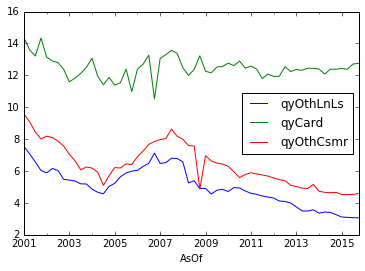

In [28]:
dy3[['qyOthLnLs','qyCard','qyOthCsmr']].plot()

In [29]:
dy3.ix[0][['aEarnAst','aAstPc','aLiabPc','eDDA','netDDA']]

aEarnAst    5.86382e+09
aAstPc      5.86382e+09
aLiabPc     5.67291e+09
eDDA         7.3563e+08
netDDA      4.51901e+08
Name: 2001-03-31 00:00:00, dtype: object

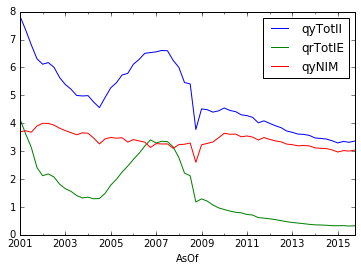

In [30]:
dy3[['qyTotII','qrTotIE','qyNIM']].plot()

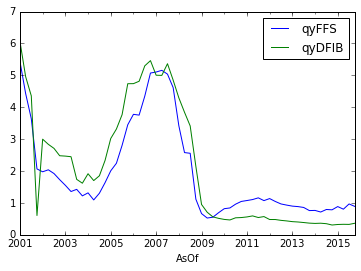

In [31]:
dy3[['qyFFS','qyDFIB']].plot()

In [32]:
dy3.head(2)

Grp   nbr       eTotAst      eTangEq         eDDA  \
AsOf                                                                    
2001-03-31  grpTotUSx00  8857  6.619299e+09  474642337.0  735630015.0   
2001-06-30  grpTotUSx00  8790  6.670875e+09  482117312.0  767738647.0   

             qyNetII   qyTotII   qyTotLn      qyRE      qyCI     ...       \
AsOf                                                             ...        
2001-03-31  3.692046  7.841322  8.825734  8.458727  8.714799     ...        
2001-06-30  3.727612  7.347639  8.293801  7.955809  8.165959     ...        

                  aOLbIB    aFF_TA        aCsmr       aSavNow           aCD  \
AsOf                                                                          
2001-03-31  1.123344e+09 -1.149463  565178660.0  1.658162e+09  1.480339e+09   
2001-06-30  1.143565e+09 -1.166986  572302418.0  1.731745e+09  1.474806e+09   

            rNIM       aLnLsPc        aAstPc       aLiabPc       netDDA  
AsOf                                                                     
2001-03-31   NaN  4.017461e+09  5.863822e+09  5.672909e+09  451900692.0  
2001-06-30   NaN  4.052875e+09  5.935800e+09  5.777495e+09  443925675.0  

[2 rows x 77 columns]

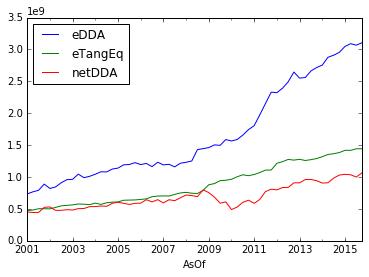

In [33]:
dy3[['eDDA','eTangEq','netDDA']].plot()

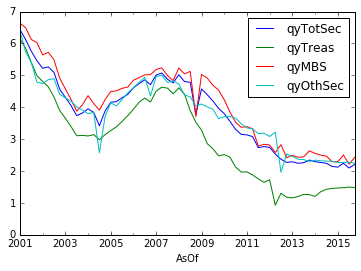

In [34]:
dy3[['qyTotSec','qyTreas','qyMBS','qyOthSec']].plot()

In [35]:
ldxall.tail(2)

r0        r1        r3        r6       r12       r24  \
Date                                                                     
2015-09-30  0.138565  0.198036  0.303004  0.446059  0.445556  0.675278   
2015-12-31  0.162222  0.255253  0.363004  0.530224  0.502778  0.725139   

                 r36       r48       r60       r84      r120      r144  \
Date                                                                     
2015-09-30  0.891296  1.122778  1.501056  2.316587  3.451056  3.737475   
2015-12-31  0.945278  1.143194  1.496944  2.244325  3.382139  3.682372   

                r180      r240      r300      r360     Prime  DDA  
Date                                                               
2015-09-30  4.185031  4.925406  5.579070  6.273378  3.295139    0  
2015-12-31  4.108569  4.872263  5.511085  6.202494  3.335694    0

In [36]:
dy3.to_csv('NIMdata_FDIC_'+grp+'_exp.csv') 
'NIMdata_FDIC_'+grp+'_exp.csv'

'NIMdata_FDIC_grpTotUSx00_exp.csv'

In [37]:
len(dy3)

60

In [38]:
[x for x in dy3.columns if 'DDA' in x]

['eDDA', 'netDDA']

In [39]:
grp

'grpTotUSx00'

In [40]:
## select time period: 2001-2014, 2001-2007, 2008-2014 (14y, 7y, 7y)
#r0 = '2001_2014'
#r0 = '2001_2007'
r0 = '2001_2010'
#r0 = '2005_2014'
ra = int(r0[0:4])
rb = int(r0[-4:])
r0, ra, rb

('2001_2010', 2001, 2010)

In [41]:
ldx = ldxall[str(ra):str(rb)]
dy3 = dy3all[str(ra):str(rb)]

In [42]:
ldx.head(2)

r0        r1        r3        r6      r12       r24  \
Date                                                                    
2001-03-31  5.671019  5.584845  5.925261  6.289939  6.58615  6.441290   
2001-06-30  4.386759  4.350878  4.636757  5.156984  5.97003  6.360413   

                 r36       r48       r60       r84      r120      r144  \
Date                                                                     
2001-03-31  6.103628  6.175796  6.266308  6.514782  6.895917  7.321731   
2001-06-30  6.102206  6.095638  6.223161  6.481845  6.828667  7.247147   

                r180      r240      r300      r360     Prime  DDA  
Date                                                               
2001-03-31  7.729644  9.055592  9.238483  9.023238  8.743102    0  
2001-06-30  7.689809  8.956643  9.214836  9.019233  7.441944    0

In [43]:
ldx.tail(2)

r0        r1        r3        r6       r12       r24  \
Date                                                                     
2010-09-30  0.189259  0.292869  0.459604  0.600520  0.593889  1.486944   
2010-12-31  0.189259  0.260921  0.302902  0.574779  0.550556  1.222222   

                 r36       r48       r60       r84      r120      r144  \
Date                                                                     
2010-09-30  2.568241  3.456181  3.955611  4.241468  4.762000  5.129497   
2010-12-31  2.265370  3.216111  3.800000  4.170159  4.659722  5.072759   

                r180      r240      r300      r360     Prime  DDA  
Date                                                               
2010-09-30  5.498565  6.129145  6.833502  7.908135  3.295139    0  
2010-12-31  5.440070  6.054240  6.757552  7.834043  3.295139    0

In [44]:
dy3.head(2)

Grp   nbr       eTotAst      eTangEq         eDDA  \
AsOf                                                                    
2001-03-31  grpTotUSx00  8857  6.619299e+09  474642337.0  735630015.0   
2001-06-30  grpTotUSx00  8790  6.670875e+09  482117312.0  767738647.0   

             qyNetII   qyTotII   qyTotLn      qyRE      qyCI     ...       \
AsOf                                                             ...        
2001-03-31  3.692046  7.841322  8.825734  8.458727  8.714799     ...        
2001-06-30  3.727612  7.347639  8.293801  7.955809  8.165959     ...        

                  aOLbIB    aFF_TA        aCsmr       aSavNow           aCD  \
AsOf                                                                          
2001-03-31  1.123344e+09 -1.149463  565178660.0  1.658162e+09  1.480339e+09   
2001-06-30  1.143565e+09 -1.166986  572302418.0  1.731745e+09  1.474806e+09   

            rNIM       aLnLsPc        aAstPc       aLiabPc       netDDA  
AsOf                                                                     
2001-03-31   NaN  4.017461e+09  5.863822e+09  5.672909e+09  451900692.0  
2001-06-30   NaN  4.052875e+09  5.935800e+09  5.777495e+09  443925675.0  

[2 rows x 77 columns]

In [45]:
dy3.tail(2)

Grp   nbr       eTotAst       eTangEq          eDDA  \
AsOf                                                                      
2010-09-30  grpTotUSx00  7094  1.247603e+10  1.034996e+09  1.657484e+09   
2010-12-31  grpTotUSx00  6999  1.241701e+10  1.021286e+09  1.742985e+09   

             qyNetII   qyTotII   qyTotLn      qyRE      qyCI     ...       \
AsOf                                                             ...        
2010-09-30  3.608704  4.415571  5.734365  4.998700  5.173196     ...        
2010-12-31  3.513222  4.300354  5.629657  4.940462  5.115440     ...        

                  aOLbIB    aFF_TA         aCsmr       aSavNow           aCD  \
AsOf                                                                           
2010-09-30  1.690409e+09  5.107983  1.154753e+09  4.444241e+09  1.880439e+09   
2010-12-31  1.632529e+09  5.348439  1.134519e+09  4.679019e+09  1.800353e+09   

                rNIM       aLnLsPc        aAstPc       aLiabPc       netDDA  
AsOf                                                                         
2010-09-30  3.582245  6.789318e+09  1.108292e+10  1.110189e+10  603514290.0  
2010-12-31  3.591128  6.802800e+09  1.123539e+10  1.132050e+10  636594252.0  

[2 rows x 77 columns]

In [46]:
dy3.columns

Index([u'Grp', u'nbr', u'eTotAst', u'eTangEq', u'eDDA', u'qyNetII', u'qyTotII',
       u'qyTotLn', u'qyRE', u'qyCI', u'qyCard', u'qyOthCsmr', u'qyOthLnLs',
       u'qyDFIB', u'qyTreas', u'qyMBS', u'qyOthSec', u'qyFFS', u'qyOAstIB',
       u'qyTotLnLs', u'qyTotSec', u'qrTotIE', u'qrNOW', u'qrSav', u'qrCDun',
       u'qrCDov', u'qrFFP', u'qrBorr', u'qrOLbIB', u'qrDepIB', u'qrFDepIB',
       u'qyNIM', u'qyCsmr', u'qrSavNow', u'qrCD', u'aTotAst', u'aDLn', u'aSFR',
       u'aRE', u'aTotRE', u'aAg', u'aCI', u'aCard', u'aOthCsmr', u'aFLn',
       u'aLeas', u'aTrad', u'aDFIB', u'aTreas', u'aMBS', u'aOSec', u'aFFS',
       u'aTotLn', u'aTotLnLs', u'aOthLnLs', u'aTotSec', u'aOAstIB',
       u'aEarnAst', u'aNOW', u'aSav', u'aCDun', u'aCDov', u'aDDepIB',
       u'aFDepIB', u'aFFP', u'aBorr', u'aDepIB', u'aOLbIB', u'aFF_TA',
       u'aCsmr', u'aSavNow', u'aCD', u'rNIM', u'aLnLsPc', u'aAstPc',
       u'aLiabPc', u'netDDA'],
      dtype='object')

In [47]:
#y9col=['qyRE','qyCI','qyCsmr','qyTotLnLs','qyTotSec','qyOAstIB','DDA','qrDepIB','qrOLbIB']
y9col=['qyRE','qyCI','qyCsmr','qyTotSec','qyOAstIB','DDA','qrSavNow','qrCD','qrFDepIB','qrOLbIB','Prime']
#yzcol=['qyRE','qyCI','qyCard','qyOthCsmr','qyCsmr','qyTotSec','qyOAstIB','Prime','DDA','qrNOW','qrSav']
#yzcol = yzcol+['qrSavNow','qrCDun','qrCDov','qrCD','qrFDepIB','qrFFP','qrBorr','qrOLbIB','qyTotII','qrTotIE','qyNIM']
yzcol=['qyRE','qyCI','qyCsmr','qyTotSec','qyOthLnLs','qyOAstIB','Prime','DDA']
yzcol = yzcol+['qrSavNow','qrCD','qrFDepIB','qrOLbIB']
yzcol

['qyRE',
 'qyCI',
 'qyCsmr',
 'qyTotSec',
 'qyOthLnLs',
 'qyOAstIB',
 'Prime',
 'DDA',
 'qrSavNow',
 'qrCD',
 'qrFDepIB',
 'qrOLbIB']

In [48]:
mx = np.arange(0,1.05,.05)  # mixes to analyze
yrcol=['grp','prod','mt1','mt2','mt3','mx1','mx2','dur','spd','sd']
yr = pd.DataFrame(columns=yrcol)

In [49]:
mzlst

[0, 1, 3, 6, 12, 24, 36, 48, 60, 84, 120]

In [50]:
rzlst

['r0',
 'r1',
 'r3',
 'r6',
 'r12',
 'r24',
 'r36',
 'r48',
 'r60',
 'r84',
 'r120',
 'Prime',
 'DDA']

In [51]:
###########################################################
## WARNING:  this cell can take over 6hours to complete!!!!
## process set of products in ycol:

for prd in yzcol:
#for prd in ['qyRE']:
  if prd == 'DDA':
    ldx['prd'] = 0
  elif prd == 'Prime':
    ldx['prd'] = ldx['Prime']
  else:
    ldx['prd'] = dy3[prd]
  print(prd+' started at:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
#  for i in [0,1]:
  for i in np.arange(0,len(mzlst)-2):
    mt1 = rzlst[i]
    for j in np.arange(i+1,len(mzlst)-1):
      mt2 = rzlst[j]
      for k in np.arange(j+1,len(mzlst)):
        mt3 = rzlst[k]
        for m1 in mx:
          for m2 in mx:
            if (m1==0)&(m2==0): sd=99999
            if (m1 + m2) <= 1:
              ldx['spd'] = ldx.apply(lambda x: x['prd'] - (m1*x[mt1] + m2*x[mt2] + (1-m1-m2)*x[mt3]),axis=1)
              if ldx['spd'].std() < sd:
                sd = ldx['spd'].std()
                avg = ldx['spd'].mean()
                dur = m1 * d20dct[mzlst[i]] + m2* d20dct[mzlst[j]] + (1-m1-m2)* d20dct[mzlst[k]]
                ydct = dict(zip(yrcol,[grp,prd,mt1,mt2,mt3,m1,m2,dur,avg,sd]))
            else:
              pass
        yr = yr.append(ydct,ignore_index=True)
    print(mt1, sd, dur, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


('qyRE started at:', '2016-05-30 10:13:05')
('r0', 0.4023495176179964, 2.0759083699574994, '2016-05-30 10:21:17')
('r1', 0.45137524209824165, 2.0904917032908328, '2016-05-30 10:27:55')
('r3', 0.458205771567428, 2.1196583699574996, '2016-05-30 10:33:00')
('r6', 0.4297702851877161, 2.1634083699574993, '2016-05-30 10:36:52')
('r12', 0.3922511141188488, 2.1311180021859997, '2016-05-30 10:39:38')
('r24', 0.5192867504569866, 2.1069681187349998, '2016-05-30 10:41:29')
('r36', 0.7001170083945274, 2.4264432850920001, '2016-05-30 10:42:34')
('r48', 0.7843985921600343, 3.0684306579899996, '2016-05-30 10:43:07')
('r60', 0.7853945806807118, 3.1937051845499997, '2016-05-30 10:43:18')
('qyCI started at:', '2016-05-30 10:43:18')
('r0', 0.3566585271368293, 1.4371673330474997, '2016-05-30 10:51:31')
('r1', 0.4828047325159713, 1.6176859256083331, '2016-05-30 10:58:04')
('r3', 0.5555308274486103, 1.6593525922749999, '2016-05-30 11:03:10')
('r6', 0.587508185354593, 1.7218525922749999, '2016-05-30 11:07:02'

In [52]:
yr.head()

grp  prod mt1 mt2  mt3  mx1  mx2       dur       spd        sd
0  grpTotUSx00  qyRE  r0  r1   r3  0.9  0.0  0.012500  3.709549  1.198003
1  grpTotUSx00  qyRE  r0  r1   r6  0.5  0.0  0.125000  3.470695  1.157829
2  grpTotUSx00  qyRE  r0  r1  r12  0.2  0.0  0.429790  3.165374  1.025736
3  grpTotUSx00  qyRE  r0  r1  r24  0.3  0.0  0.714162  2.808744  0.690836
4  grpTotUSx00  qyRE  r0  r1  r36  0.4  0.0  0.893207  2.650664  0.433659

In [53]:
yrn = yr.ix[yr.groupby(['prod']).apply(lambda x: x['sd'].idxmin())]
yrn

grp       prod mt1  mt2   mt3   mx1   mx2       dur       spd  \
1178  grpTotUSx00        DDA  r0   r6  r120  0.00  0.05  4.086785 -5.693406   
991   grpTotUSx00      Prime  r0   r1    r6  0.75  0.20  0.020833  3.012379   
1511  grpTotUSx00       qrCD  r0  r12   r48  0.20  0.35  1.061465 -0.285886   
1655  grpTotUSx00   qrFDepIB  r0   r1   r48  0.55  0.15  0.588538 -0.661015   
1850  grpTotUSx00    qrOLbIB  r0  r36   r48  0.75  0.20  0.394784  0.862204   
1343  grpTotUSx00   qrSavNow  r0   r6  r120  0.05  0.30  2.862669 -3.581131   
172   grpTotUSx00       qyCI  r0   r1   r84  0.55  0.00  1.437167  2.614718   
365   grpTotUSx00     qyCsmr  r0  r36   r48  0.25  0.10  1.410492  5.240680   
830   grpTotUSx00   qyOAstIB  r0   r1   r48  0.25  0.40  0.696003 -0.451823   
680   grpTotUSx00  qyOthLnLs  r0   r6   r48  0.35  0.10  1.092528  2.042832   
36    grpTotUSx00       qyRE  r0  r36   r60  0.40  0.20  1.248171  2.403060   
616   grpTotUSx00   qyTotSec  r6  r36   r60  0.25  0.30  1.578343  0.334707   

            sd  
1178  0.604397  
991   0.052124  
1511  0.194878  
1655  0.209809  
1850  0.212892  
1343  0.310308  
172   0.356659  
365   0.617770  
830   0.230264  
680   0.343466  
36    0.321057  
616   0.301537

In [54]:
yr.to_csv('yldreg_3mat_FDIC_'+grp+'_'+r0+'_exp.csv')
yrn.to_csv('yldreg_3matbest_FDIC_'+grp+'_'+r0+'_exp.csv')

In [55]:
'yldreg_3matbest_FDIC_'+grp+'_'+r0+'_exp.csv'

'yldreg_3matbest_FDIC_grpTotUSx00_2001_2010_exp.csv'

In [56]:
len(yr), len(yrn)

(1980, 12)

In [57]:
ydda = yr[yr['prod']=='DDA']

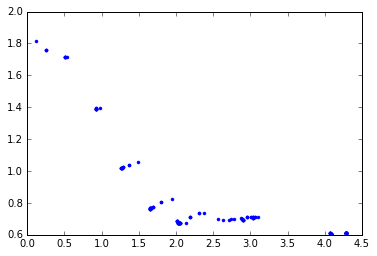

In [58]:
plt.plot(ydda['dur'],ydda['sd'],ls=' ',marker='.')